In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!cp ./drive/My\ Drive/mati-cv-trial-task.zip mati-task.zip
!unzip mati-task.zip
!rm mati-task.zip task
!mkdir output

Archive:  mati-task.zip
   creating: test/
  inflating: __MACOSX/._test         
  inflating: test/354F1.png          
  inflating: __MACOSX/test/._354F1.png  
  inflating: test/B2184.png          
  inflating: __MACOSX/test/._B2184.png  
  inflating: test/EA353.png          
  inflating: __MACOSX/test/._EA353.png  
  inflating: test/94EFC.png          
  inflating: __MACOSX/test/._94EFC.png  
  inflating: test/C9765.png          
  inflating: __MACOSX/test/._C9765.png  
  inflating: test/10a59.png          
  inflating: __MACOSX/test/._10a59.png  
  inflating: test/C0B6E.png          
  inflating: __MACOSX/test/._C0B6E.png  
  inflating: test/CDEA5.png          
  inflating: __MACOSX/test/._CDEA5.png  
  inflating: test/d21e8.png          
  inflating: __MACOSX/test/._d21e8.png  
  inflating: test/7D676.png          
  inflating: __MACOSX/test/._7D676.png  
  inflating: test/EB101.png          
  inflating: __MACOSX/test/._EB101.png  
  inflating: test/9aae5.png          
  inflating:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
from tqdm import tqdm
import glob
import shutil
import cv2
import torch
import string

0
0


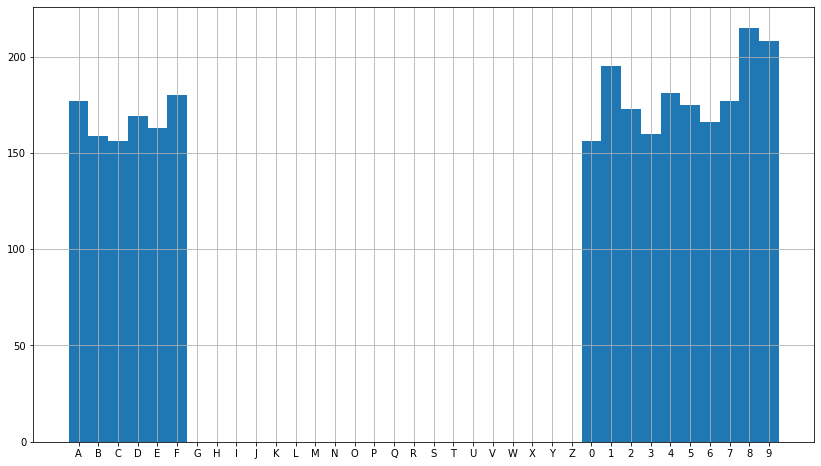

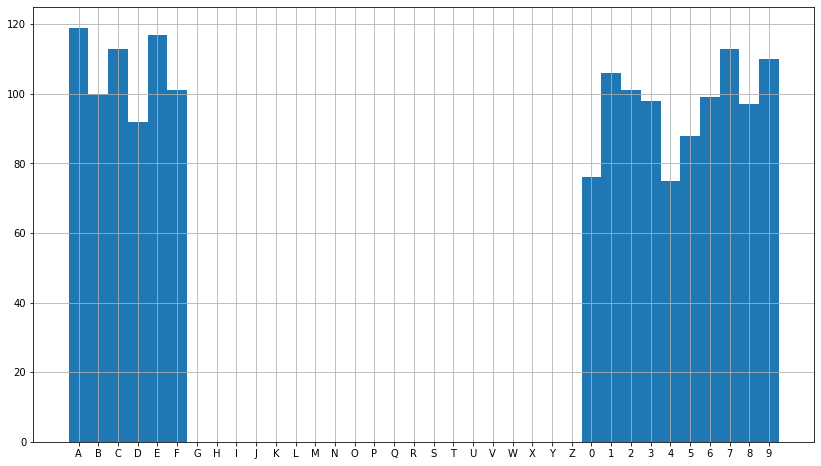

In [4]:
ROOT = os.getcwd()
PATH_TRAIN = os.path.join(ROOT, 'train')
PATH_TEST = os.path.join(ROOT, 'test')
PATH_VAL = os.path.join(ROOT, 'val')


def hist_distribution(dir):
    assert os.path.exists(dir), -1
    hist_dict = {elem: 0 for elem in string.ascii_uppercase}
    for elem in string.digits:
        hist_dict[elem] = 0
    images_list = glob.glob1(dir, "*.png")
    for ans in images_list:
        for elem in ans.split('.')[0].upper():
            hist_dict[elem] += 1
    fig, ax = plt.subplots()
    ax.bar(hist_dict.keys(), hist_dict.values(), width=1)
    fig.set_figwidth(14)
    fig.set_figheight(8)
    plt.grid()
    plt.show



def checker(dir):
    assert os.path.exists(dir), -1
    images_list = glob.glob1(dir, "*.png")
    count = 0
    for img_path in images_list:
        # if len(img_path) != 9:
        #     print(img_path)
        #     count += 1
        for i in 'LPSQGKNM':
            if i in img_path:
                print(img_path)
                os.remove(os.path.join(dir, img_path))
    print(count)


def captcha_show(dir):
    assert os.path.exists(dir), -1
    images_list = glob.glob1(dir, "*.png")
    random_images = np.random.choice(images_list, 8, replace=True)

    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 8))
    for i, img_name in enumerate(random_images):
        img = mpimg.imread(os.path.join(dir, img_name))
        ax[i // 2, i % 2].imshow(img)
        ax[i // 2, i % 2].set_title(img_name)
        ax[i // 2, i % 2].axis('off')
    
    plt.show()


def decode(pred):
    const = "ABCDEF" + string.digits
    lenght = len(const)
    targets = np.zeros((pred.shape[0], 5), dtype=str)
    for i in range(pred.shape[0]):
        c1 = const[torch.argmax(pred[i][:lenght])]
        c2 = const[torch.argmax(pred[i][lenght:2*lenght])]
        c3 = const[torch.argmax(pred[i][2*lenght:3*lenght])]
        c4 = const[torch.argmax(pred[i][3*lenght:4*lenght])]
        c5 = const[torch.argmax(pred[i][4*lenght:])]
        targets[i] = np.array([c1, c2, c3, c4, c5])
    return targets


def encode(label):
    const = "ABCDEF" + string.digits
    lenght = len(const)
    multi_labels = np.zeros((lenght * 5))
    for i, c in enumerate(label):
        multi_labels[i*lenght:(i+1)*lenght][const.index(c)] = 1
    return multi_labels


hist_distribution(PATH_TRAIN)
# hist_distribution(PATH_VAL)
hist_distribution(PATH_TEST)
# captcha_show(PATH_TRAIN)
checker(PATH_TEST)
checker(PATH_TRAIN)

In [ ]:
os.makedirs(PATH_VAL, exist_ok=True)
images_list = os.listdir(PATH_TRAIN)
for i, img_path in enumerate(images_list):
    if i % 6 == 0:
        shutil.move(os.path.join(PATH_TRAIN, img_path), os.path.join(PATH_VAL, img_path))


In [ ]:
!ls ./train | wc
# !ls ./val | wc
!ls ./test | wc

    562     562    5620
    321     321    3210


In [ ]:
import torchvision
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


class CaptchaDataset(Dataset):
    def __init__(self, path, transform=None):
        assert os.path.exists(path), -1
        self.images = [os.path.join(path, img) for img in os.listdir(path)]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path)
        label = img_path.split('/')[-1][:5].upper()
        label = encode(label)
        if self.transform is not None:
            img = self.transform(img)
        return img, torch.from_numpy(label)

In [ ]:
# Create dataloaders
train_transforms = transforms.Compose([
    # transforms.Resize(224),
    transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    # transforms.Resize(224),                         
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = CaptchaDataset(PATH_TRAIN, transform=train_transforms)
# val_dataset = CaptchaDataset(PATH_VAL, transform=test_transforms)
test_dataset = CaptchaDataset(PATH_TEST, transform=test_transforms)
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size, drop_last=True)

# val_dataloader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, drop_last=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, drop_last=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


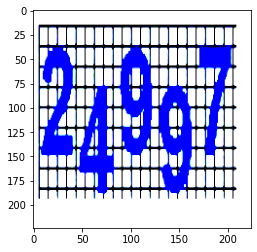

In [ ]:
plt.imshow(np.array(train_dataset[2][0]).transpose(1, 2 ,0))

In [ ]:
# class CaptchaNet(nn.Module):
#     def __init__(self):
#         super(CaptchaNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=3, padding=1),
#             nn.BatchNorm2d(8),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
        
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(8, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
        
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.fc_1 = nn.Linear(128 * 14 * 14, 4096)
#         self.bn_1 = nn.BatchNorm1d(4096)
#         self.relu_1 = nn.ReLU()
#         self.fc_2 = nn.Linear(4096, 1024)
#         self.bn_2 = nn.BatchNorm1d(1024)
#         self.relu_2 = nn.ReLU()
#         self.fc_3 = nn.Linear(1024, 16 * 5)
    
#     def forward(self, x):
#         # print(x.shape)
#         out = self.layer1(x)
#         # print(out.shape)
#         out = self.layer2(out)
#         # print(out.shape)
#         out = self.layer3(out)
#         # print(out.shape)
#         out = self.layer4(out)
#         # print(out.shape)
#         out = out.reshape(out.size(0), -1)
#         # print(out.shape)

#         out = self.fc_1(out)
#         out = self.bn_1(out)
#         out = self.relu_1(out)
#         out = self.fc_2(out)
#         out = self.bn_2(out)
#         out = self.relu_2(out)
#         out = self.fc_3(out)

#         return out


# model = CaptchaNet()

In [ ]:
# Create resnet34 and freeze the first 50 layers
model = models.resnet34(pretrained=True)

c = 0
for param in model.parameters():
    c += 1
    if c < 50:
      param.requires_grad = False

# Probability for each symbol
model.fc = nn.Linear(in_features=512, out_features=16 * 5, bias=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = test_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()

                running_acc += (decode(preds) == decode(labels)).all(axis=1).mean()

            scheduler.step()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase=='train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc)
                torch.save(model, os.path.join(ROOT, 'output', str(str(epoch) + '.pt')))
            else:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model, loss_train, loss_val, acc_train, acc_val

In [ ]:
model, loss_train, loss_val, acc_train, acc_val = train_model(model, loss, optimizer, scheduler, num_epochs=50)

Epoch 0/49:


100%|██████████| 70/70 [00:05<00:00, 13.67it/s]


train Loss: 0.2588 Acc: 0.0000


100%|██████████| 41/41 [00:01<00:00, 20.89it/s]

val Loss: 0.2391 Acc: 0.0000
Epoch 1/49:



100%|██████████| 70/70 [00:05<00:00, 13.79it/s]


train Loss: 0.2247 Acc: 0.0000


100%|██████████| 41/41 [00:01<00:00, 20.66it/s]

val Loss: 0.2167 Acc: 0.0030
Epoch 2/49:



100%|██████████| 70/70 [00:05<00:00, 13.84it/s]


train Loss: 0.1911 Acc: 0.0036


100%|██████████| 41/41 [00:01<00:00, 21.05it/s]

val Loss: 0.1719 Acc: 0.0030
Epoch 3/49:



100%|██████████| 70/70 [00:05<00:00, 13.77it/s]


train Loss: 0.1486 Acc: 0.0304


100%|██████████| 41/41 [00:02<00:00, 20.46it/s]

val Loss: 0.1321 Acc: 0.0305
Epoch 4/49:



100%|██████████| 70/70 [00:05<00:00, 13.81it/s]

train Loss: 0.1104 Acc: 0.1446



100%|██████████| 41/41 [00:01<00:00, 21.09it/s]

val Loss: 0.1033 Acc: 0.0915
Epoch 5/49:



100%|██████████| 70/70 [00:05<00:00, 13.76it/s]


train Loss: 0.0813 Acc: 0.4107


100%|██████████| 41/41 [00:02<00:00, 20.49it/s]

val Loss: 0.0787 Acc: 0.3201
Epoch 6/49:



100%|██████████| 70/70 [00:05<00:00, 13.72it/s]

train Loss: 0.0572 Acc: 0.6250



100%|██████████| 41/41 [00:02<00:00, 16.76it/s]

val Loss: 0.0558 Acc: 0.5213
Epoch 7/49:



100%|██████████| 70/70 [00:05<00:00, 12.54it/s]


train Loss: 0.0434 Acc: 0.7875


100%|██████████| 41/41 [00:02<00:00, 16.70it/s]

val Loss: 0.0419 Acc: 0.7256
Epoch 8/49:



100%|██████████| 70/70 [00:05<00:00, 12.55it/s]


train Loss: 0.0307 Acc: 0.8929


100%|██████████| 41/41 [00:01<00:00, 20.93it/s]

val Loss: 0.0329 Acc: 0.8140
Epoch 9/49:



100%|██████████| 70/70 [00:05<00:00, 13.57it/s]


train Loss: 0.0233 Acc: 0.9357


100%|██████████| 41/41 [00:02<00:00, 20.09it/s]

val Loss: 0.0271 Acc: 0.8689
Epoch 10/49:



100%|██████████| 70/70 [00:05<00:00, 13.71it/s]

train Loss: 0.0190 Acc: 0.9643



100%|██████████| 41/41 [00:01<00:00, 20.64it/s]

val Loss: 0.0246 Acc: 0.8567
Epoch 11/49:



100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


train Loss: 0.0159 Acc: 0.9696


100%|██████████| 41/41 [00:01<00:00, 20.50it/s]

val Loss: 0.0218 Acc: 0.8598
Epoch 12/49:



100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


train Loss: 0.0129 Acc: 0.9768


100%|██████████| 41/41 [00:01<00:00, 20.61it/s]

val Loss: 0.0190 Acc: 0.9055
Epoch 13/49:



100%|██████████| 70/70 [00:05<00:00, 13.55it/s]


train Loss: 0.0107 Acc: 0.9821


100%|██████████| 41/41 [00:02<00:00, 20.24it/s]

val Loss: 0.0135 Acc: 0.9421
Epoch 14/49:



100%|██████████| 70/70 [00:05<00:00, 13.60it/s]


train Loss: 0.0081 Acc: 0.9982


100%|██████████| 41/41 [00:01<00:00, 20.65it/s]

val Loss: 0.0123 Acc: 0.9421
Epoch 15/49:



100%|██████████| 70/70 [00:05<00:00, 13.65it/s]


train Loss: 0.0069 Acc: 0.9982


100%|██████████| 41/41 [00:02<00:00, 20.32it/s]

val Loss: 0.0116 Acc: 0.9482
Epoch 16/49:



100%|██████████| 70/70 [00:05<00:00, 13.72it/s]


train Loss: 0.0069 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.85it/s]

val Loss: 0.0111 Acc: 0.9390
Epoch 17/49:



100%|██████████| 70/70 [00:05<00:00, 13.71it/s]


train Loss: 0.0063 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.30it/s]

val Loss: 0.0111 Acc: 0.9482
Epoch 18/49:



100%|██████████| 70/70 [00:05<00:00, 13.70it/s]

train Loss: 0.0060 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.67it/s]

val Loss: 0.0105 Acc: 0.9512
Epoch 19/49:



100%|██████████| 70/70 [00:05<00:00, 13.54it/s]


train Loss: 0.0056 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.51it/s]

val Loss: 0.0108 Acc: 0.9482
Epoch 20/49:



100%|██████████| 70/70 [00:05<00:00, 13.58it/s]

train Loss: 0.0056 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.70it/s]

val Loss: 0.0108 Acc: 0.9390
Epoch 21/49:



100%|██████████| 70/70 [00:05<00:00, 13.48it/s]


train Loss: 0.0056 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.22it/s]

val Loss: 0.0106 Acc: 0.9451
Epoch 22/49:



100%|██████████| 70/70 [00:05<00:00, 13.52it/s]

train Loss: 0.0056 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.59it/s]

val Loss: 0.0105 Acc: 0.9482
Epoch 23/49:



100%|██████████| 70/70 [00:05<00:00, 13.64it/s]


train Loss: 0.0050 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.18it/s]

val Loss: 0.0100 Acc: 0.9543
Epoch 24/49:



100%|██████████| 70/70 [00:05<00:00, 13.68it/s]


train Loss: 0.0052 Acc: 0.9982


100%|██████████| 41/41 [00:01<00:00, 20.62it/s]

val Loss: 0.0100 Acc: 0.9573
Epoch 25/49:



100%|██████████| 70/70 [00:05<00:00, 13.53it/s]

train Loss: 0.0053 Acc: 1.0000



100%|██████████| 41/41 [00:02<00:00, 20.29it/s]

val Loss: 0.0097 Acc: 0.9573
Epoch 26/49:



100%|██████████| 70/70 [00:05<00:00, 13.72it/s]


train Loss: 0.0047 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.75it/s]

val Loss: 0.0097 Acc: 0.9543
Epoch 27/49:



100%|██████████| 70/70 [00:05<00:00, 13.67it/s]


train Loss: 0.0049 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.72it/s]

val Loss: 0.0096 Acc: 0.9512
Epoch 28/49:



100%|██████████| 70/70 [00:05<00:00, 13.61it/s]

train Loss: 0.0050 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.77it/s]

val Loss: 0.0098 Acc: 0.9543
Epoch 29/49:



100%|██████████| 70/70 [00:05<00:00, 13.58it/s]


train Loss: 0.0049 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.59it/s]

val Loss: 0.0096 Acc: 0.9573
Epoch 30/49:



100%|██████████| 70/70 [00:05<00:00, 13.64it/s]


train Loss: 0.0046 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.81it/s]

val Loss: 0.0096 Acc: 0.9543
Epoch 31/49:



100%|██████████| 70/70 [00:05<00:00, 13.67it/s]


train Loss: 0.0047 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.08it/s]

val Loss: 0.0097 Acc: 0.9543
Epoch 32/49:



100%|██████████| 70/70 [00:05<00:00, 13.63it/s]

train Loss: 0.0046 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.62it/s]

val Loss: 0.0094 Acc: 0.9573
Epoch 33/49:



100%|██████████| 70/70 [00:05<00:00, 13.55it/s]


train Loss: 0.0044 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 19.85it/s]

val Loss: 0.0096 Acc: 0.9543
Epoch 34/49:



100%|██████████| 70/70 [00:05<00:00, 13.62it/s]


train Loss: 0.0049 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 19.45it/s]

val Loss: 0.0096 Acc: 0.9543
Epoch 35/49:



100%|██████████| 70/70 [00:05<00:00, 13.56it/s]


train Loss: 0.0047 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.52it/s]

val Loss: 0.0096 Acc: 0.9543
Epoch 36/49:



100%|██████████| 70/70 [00:05<00:00, 13.34it/s]

train Loss: 0.0044 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.56it/s]

val Loss: 0.0097 Acc: 0.9573
Epoch 37/49:



100%|██████████| 70/70 [00:05<00:00, 13.64it/s]


train Loss: 0.0045 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 19.87it/s]

val Loss: 0.0096 Acc: 0.9512
Epoch 38/49:



100%|██████████| 70/70 [00:05<00:00, 13.41it/s]


train Loss: 0.0044 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.51it/s]

val Loss: 0.0097 Acc: 0.9512
Epoch 39/49:



100%|██████████| 70/70 [00:05<00:00, 13.29it/s]


train Loss: 0.0044 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.22it/s]

val Loss: 0.0095 Acc: 0.9573
Epoch 40/49:



100%|██████████| 70/70 [00:05<00:00, 13.50it/s]


train Loss: 0.0045 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.06it/s]

val Loss: 0.0095 Acc: 0.9512
Epoch 41/49:



100%|██████████| 70/70 [00:05<00:00, 13.68it/s]


train Loss: 0.0044 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 19.53it/s]

val Loss: 0.0096 Acc: 0.9543
Epoch 42/49:



100%|██████████| 70/70 [00:05<00:00, 13.62it/s]


train Loss: 0.0047 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.43it/s]

val Loss: 0.0095 Acc: 0.9604
Epoch 43/49:



100%|██████████| 70/70 [00:05<00:00, 13.49it/s]


train Loss: 0.0044 Acc: 1.0000


100%|██████████| 41/41 [00:01<00:00, 20.73it/s]

val Loss: 0.0097 Acc: 0.9482
Epoch 44/49:



100%|██████████| 70/70 [00:05<00:00, 13.55it/s]


train Loss: 0.0041 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.03it/s]

val Loss: 0.0096 Acc: 0.9573
Epoch 45/49:



100%|██████████| 70/70 [00:05<00:00, 13.67it/s]


train Loss: 0.0046 Acc: 0.9982


100%|██████████| 41/41 [00:01<00:00, 20.70it/s]

val Loss: 0.0094 Acc: 0.9543


Epoch 46/49:


100%|██████████| 70/70 [00:05<00:00, 13.55it/s]


train Loss: 0.0043 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.05it/s]

val Loss: 0.0096 Acc: 0.9543
Epoch 47/49:



100%|██████████| 70/70 [00:05<00:00, 13.62it/s]

train Loss: 0.0046 Acc: 1.0000



100%|██████████| 41/41 [00:02<00:00, 19.93it/s]

val Loss: 0.0097 Acc: 0.9512
Epoch 48/49:



100%|██████████| 70/70 [00:05<00:00, 13.71it/s]

train Loss: 0.0040 Acc: 1.0000



100%|██████████| 41/41 [00:01<00:00, 20.82it/s]

val Loss: 0.0095 Acc: 0.9573
Epoch 49/49:



100%|██████████| 70/70 [00:05<00:00, 13.64it/s]


train Loss: 0.0042 Acc: 1.0000


100%|██████████| 41/41 [00:02<00:00, 20.28it/s]

val Loss: 0.0096 Acc: 0.9512


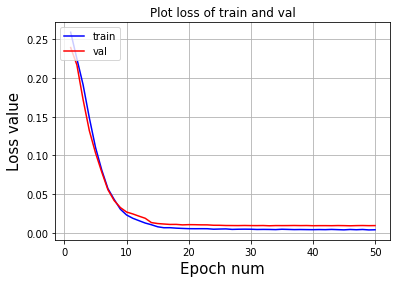

In [ ]:
num_epochs = 50
plt.plot([i+1 for i in range(num_epochs)], loss_train, label='train', color='b')
plt.plot([i+1 for i in range(num_epochs)], loss_val, label='val', color='r')
plt.legend(loc='upper left')
plt.title('Plot loss of train and val')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid()
plt.show()

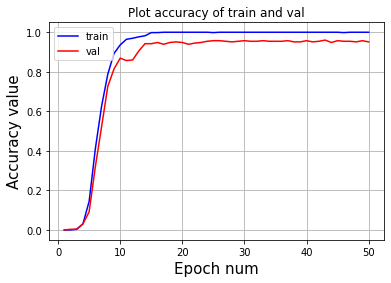

In [ ]:
plt.plot([i+1 for i in range(num_epochs)], acc_train, label='train', color='b')
plt.plot([i+1 for i in range(num_epochs)], acc_val, label='val', color='r')
plt.legend(loc='upper left')
plt.title('Plot accuracy of train and val')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid()
plt.show()

In [ ]:
targets = []
preds = []
model.eval()
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        pred = model(inputs)
        target, pred = decode(labels), decode(pred)
        for i in range(len(target)):
            targets.append(target[i])
            preds.append(pred[i])

100%|██████████| 41/41 [00:01<00:00, 20.77it/s]


In [ ]:
tp = 0
for pred, target in zip(preds, targets):
    if ''.join(pred) == ''.join(target):
        tp += 1
        print('prediction: ' + ''.join(pred) + '   target: ' + ''.join(target) + '   +')
    else:
      print('prediction: ' + ''.join(pred) + '   target: ' + ''.join(target))

print(tp / len(targets))

prediction: 109A9   target: 109A9   +
prediction: F1B7E   target: F1B7E   +
prediction: 9AAE5   target: 9AAE5   +
prediction: 770E3   target: 770E3   +
prediction: 7FC70   target: 7FC70   +
prediction: BEEC3   target: BEEC3   +
prediction: A9580   target: A9580   +
prediction: DA4AB   target: DA4AB   +
prediction: C9765   target: C9765   +
prediction: AF561   target: AF561   +
prediction: E641B   target: E641B   +
prediction: A46DF   target: A46DF   +
prediction: CAF9B   target: CAF9B   +
prediction: 98EAF   target: 98EAF   +
prediction: 9E82A   target: 9E82A   +
prediction: 70580   target: 70580   +
prediction: 58EB1   target: 58EB1   +
prediction: D6B92   target: D6B92   +
prediction: 7D676   target: 7D676   +
prediction: E19A9   target: E19A9   +
prediction: 54683   target: 54683   +
prediction: A6DE1   target: A6DE1   +
prediction: B9EF9   target: B9BF9
prediction: C7789   target: C7789   +
prediction: A5D4B   target: A5D4B   +
prediction: 9C7E1   target: 9C7E1   +
prediction: 394F

[['6' '8' '2' '5' 'D']]
6825D


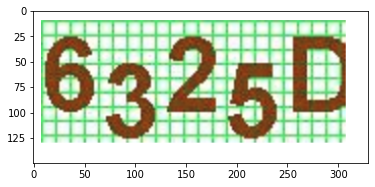

In [ ]:
model.eval()
img = cv2.imread(os.path.join(PATH_TEST, '6325D.png')) / 255
plt.imshow(img)
img = torch.Tensor(img).permute(2, 0, 1).unsqueeze_(0).to(device)
pred = model(img)
print(decode(pred))
print(''.join(decode(pred)[0]))